## Coupling in Distributed Optimization

One of the major challenges for any decomposed, distributed optimization method (e.g., multigent system, MDO method, etc.) is the management of coupling between decomposed optimization problems. 

While it is often helpful for computational reasons to separate optimization problems into multiple sub-problems, this separation may produce issues when the problems interact. Specifically, the process of optimizing each each sub-problem individually may converge to a sub-optimal overall solution in the presence of constraints relating each subproblem.

In this notebook, I will provide a basic example of this principle for illustrative purposes, using a prominent example in the literature--(see reference).

In [107]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import minimize, golden

The problem to consider is to minimize: 

$f=x_1^2 + x_2^2$

with respect to:  

$x_1$, $x_2$

subject to:

$g_1 = 4-x_2 - x_1 \leq 0$

$g_2 = x_2 + x_1 -2 \leq 0$

In [8]:
def f(x):
    return x[0]**2+x[1]**2
def g_1(x):
    return 4 - x[1] - x[0]
def g_2(x):
    return -2.0+x[1]+x[0]

This seems like a simple enough constrainted nonlinear optimization problem. Below we plot the problem to further visualize the solution.

In [9]:
def plot_problem():
    x1_map = np.linspace(0,1.5,100)
    x2_map = np.linspace(0,4,100)
    f_map = np.array([[f([x1, x2]) for x1 in x1_map] for x2 in x2_map])
    g1_map = 4.0-x1_map
    g2_map = 2.0-x1_map
    fig = plt.figure(figsize=(4,4))
    plt.contour(x1_map, x2_map, f_map, linestyles='-')
    plt.plot(x1_map, g1_map, marker="<", markevery=10, label="$g_1$")
    plt.plot(x1_map, g2_map, marker=">", markevery=10, label="$g_2$")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

    plt.plot(1,1, marker="o", label="$x^*$")
    return fig

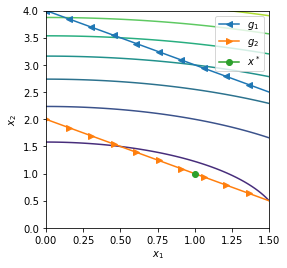

In [10]:
fig = plot_problem()
plt.legend()

In [11]:
minimize(f, [2,2], method="slsqp", constraints=[{"type":"ineq", "fun":g_1}, {"type":"ineq", "fun":g_2}])

     fun: 1.9999999999999876
     jac: array([2., 2.])
 message: 'Optimization terminated successfully'
    nfev: 6
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([1., 1.])

As shown, this problem has an optimal solution at x=[1,1]. The objective also seems readily decomposable into the optimization of two variables: the optimization of $x_1$ and the optimization of $x_2$. Using the partial derivatives of the overall problems, we may instead formulate it as two problems:

min $f$

s.t. $g_1$, $g_2$

wrt $x_1$

given $x_2$ 

In [12]:
def opt_ss1(x1_0, x2, f, g_1, g_2):
    def f_1(x1):
        return f([x1[0], x2])
    def g_11(x1):
        return g_1([x1[0], x2])
    def g_12(x1):
        return g_2([x1[0], x2])
    res = minimize(f_1, [x1_0], method="slsqp", constraints=[{"type":"ineq", "fun":g_11}, {"type":"ineq", "fun":g_12}])
    x1_opt = res.x[0]
    return x1_opt

In [13]:
x1 = opt_ss1(1,1.5, f, g_1, g_2)

In [14]:
x1

0.4999999999999982

We can similarly reformulate a problem in terms of $x_2$:


min $f$

s.t. $g_1$, $g_2$

wrt $x_2$

given $x_1$ 

In [15]:
def opt_ss2(x2_0, x1, f, g_1, g_2):
    def f_2(x2):
        return f([x1, x2[0]])
    def g_21(x2):
        return g_1([x1, x2[0]])
    def g_22(x2):
        return g_2([x1, x2[0]])
    res = minimize(f_2, [x2_0], method="slsqp", constraints=[{"type":"ineq", "fun":g_21}, {"type":"ineq", "fun":g_22}])
    x2_opt = res.x[0]
    return x2_opt

In [16]:
x2 = opt_ss1(1.5,1.5, f, g_1, g_2)

In [17]:
x2

0.4999999999999991

Now that the problems are decomposed, we may choose to optimize them in an alternating fashion. We demonstrate this below:

In [18]:
x1, x2 = [1.4,1.3]
x1_old, x2_old = [x1, x2]
xhist = []

for i in range(100):
    xhist.append([x1, x2])
    x1 = opt_ss1(x1, x2, f, g_1, g_2)
    xhist.append([x1, x2])
    x2 = opt_ss2(x2, x1, f, g_1, g_2)
    if x1==x1_old and x2==x2_old: break
    else: x1_old, x2_old = x1, x2

In [19]:
def plot_opthist(xhist):
    fig = plot_problem()
    plt.plot(np.array(xhist)[:,0], np.array(xhist)[:,1])
    plt.plot(np.array(xhist)[-1,0], np.array(xhist)[-1,1], marker="*", color="red")
    plt.plot(np.array(xhist)[0,0], np.array(xhist)[0,1], marker="+", color="green")
    return fig

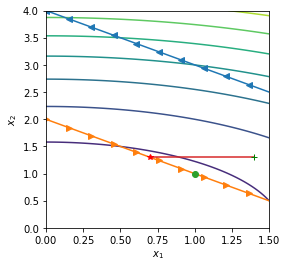

In [20]:
fig = plot_opthist(xhist)

As shown, this decomposition strategy effectively causes opt_ss1 to optimize to the constraint, where opt_ss2 on its iteration can not effectively optimize the objective. We may consider some ways to avoid this:

### Idea 1: Just switch the order.

Perhaps there is some issue with the order the objectives are optimized in. Lets see what happens if we optimize ss2 and not ss1:

In [21]:
x1, x2 = [1.4,1.3]
x1_old, x2_old = [x1, x2]
xhist = []

for i in range(100):
    xhist.append([x1, x2])
    x2 = opt_ss2(x2, x1, f, g_1, g_2)
    xhist.append([x1, x2])
    x1 = opt_ss1(x1, x2, f, g_1, g_2)
    if x1==x1_old and x2==x2_old: break
    else: x1_old, x2_old = x1, x2

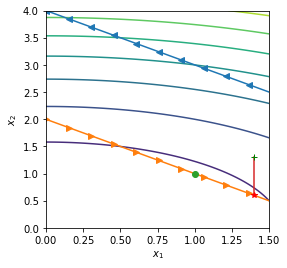

In [22]:
fig = plot_opthist(xhist)

As shown, switching optimization order does not help us because the same thing happens in the other dimension. 

### Idea 2: Align the Objectives

One topic of interest in multiagent systems is the idea of alignment between the agent and overall objective. One idea from the multiagent systems literature is to optimize the problem in terms of partial derivatives. 

In [49]:
def opt_ss1_partial(x1_0, x2, f, g_1, g_2):
    def f_1(x1):
        dfdx1 = 2*x1[0]
        return dfdx1*x1[0]
    def g_11(x1):
        return g_1([x1[0], x2])
    def g_12(x1):
        return g_2([x1[0], x2])
    res = minimize(f_1, [x1_0], method="slsqp", constraints=[{"type":"ineq", "fun":g_11}, {"type":"ineq", "fun":g_12}])
    x1_opt = res.x[0]
    return x1_opt
def opt_ss2_partial(x2_0, x1, f, g_1, g_2):
    def f_2(x2):
        return 2*x2[0]
    def g_21(x2):
        return g_1([x1, x2[0]])
    def g_22(x2):
        return g_2([x1, x2[0]])
    res = minimize(f_2, [x2_0], method="slsqp", constraints=[{"type":"ineq", "fun":g_21}, {"type":"ineq", "fun":g_22}])
    x2_opt = res.x[0]
    return x2_opt

If you're paying attention, you will notice that this problem is equivalent to the previous. Which we can see in the results:

In [50]:
x1, x2 = [1.4,1.3]
x1_old, x2_old = [x1, x2]
xhist = []

for i in range(100):
    xhist.append([x1, x2])
    x1 = opt_ss1_partial(x1, x2, f, g_1, g_2)
    xhist.append([x1, x2])
    x2 = opt_ss2_partial(x2, x1, f, g_1, g_2)
    if x1==x1_old and x2==x2_old: break
    else: x1_old, x2_old = x1, x2

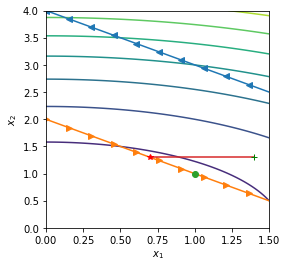

In [51]:
fig = plot_opthist(xhist)

### Idea 3: Align the Objectives more
While agents in the previous problem were able to optimize the objective directly, they were not able to account for their actions' effects on the other agent's view of the objective. We may then attempt to remedy this here using the concept of a lagrange multiplier. The idea would be to ensure that agent 1 takes the value of x2 into account when it optimizes x1. 

Since we know that the constraint $g_2$ is active at the true optimum, we can use it to relate the objectives of $f_1$ and $f_2$. The resulting optimization for x1 would be:

min $\frac{df}{dx_1} * x_1 + \frac{df}{dx_2} * \frac{\frac{dg_2}{dx_1}}{\frac{dg_2}{dx_2}} * x_1$

s.t. $g_1$, $g_2$

wrt $x_1$

given $x_2$ 

(with a similar form for the optimization of $x_2$).

In [25]:
def opt_ss1_aligned(x1_0, x2, f, g_1, g_2):
    def f_1(x1):
        dfdx1 = 2*x1[0]
        dfdx2 = 2*x2
        dg2dx2=1
        dg2dx1=1
        return dfdx1*x1[0]-(dfdx2*dg2dx1/dg2dx2)*x1[0]
    def g_11(x1):
        return g_1([x1[0], x2])
    def g_12(x1):
        return g_2([x1[0], x2])
    res = minimize(f_1, [x1_0], method="slsqp", constraints=[{"type":"ineq", "fun":g_11}, {"type":"ineq", "fun":g_12}])
    x1_opt = res.x[0]
    return x1_opt
def opt_ss2_aligned(x2_0, x1, f, g_1, g_2):
    def f_2(x2):
        dfdx1 = 2*x1
        dfdx2 = 2*x2[0]
        dg2dx2=1
        dg2dx1=1
        return dfdx2*x2[0] - (dfdx1*dg2dx1/dg2dx2)*x2[0]
    def g_21(x2):
        return g_1([x1, x2[0]])
    def g_22(x2):
        return g_2([x1, x2[0]])
    res = minimize(f_2, [x2_0], method="slsqp", constraints=[{"type":"ineq", "fun":g_21}, {"type":"ineq", "fun":g_22}])
    x2_opt = res.x[0]
    return x2_opt

Will this get us to the min? Lets see:

In [26]:
x1, x2 = [0.25,3.5]
x1_old, x2_old = [x1, x2]
xhist = []

for i in range(100):
    xhist.append([x1, x2])
    x1 = opt_ss1_aligned(x1, x2, f, g_1, g_2)
    xhist.append([x1, x2])
    x2 = opt_ss2_aligned(x2, x1, f, g_1, g_2)
    if x1==x1_old and x2==x2_old: break
    else: x1_old, x2_old = x1, x2

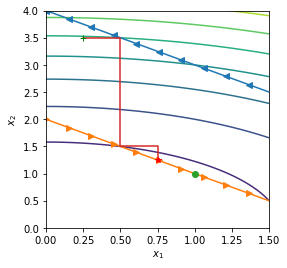

In [27]:
fig = plot_opthist(xhist)

As shown, while aligning the objectives *does* cause the agents to get closer to the true minimum, it they are not able to converge to the correct solution. Why is this? 

The answer is that the converged min corresponds to a standing point where even though each agent accounts for the relative importance of the other agent's objective in their objective, they cannot (moving their variable) improve it. That is, a move from [0.75, 1.25] in the direction of $x_1$ or $x_2$ cannot improve either objective. This is the limitation of sequential optimization of aligned objectives--while the objectives may be aligned with the global objective, there is not a gaurantee that the agents will not get stuck on their way there.

### Idea 4: Optimize the Objectives:

Since aligning the objectives alone doesn't necessarily give the agents enough incentive to approach the (very obvious) global minimum, we may instead consider more actively coordinating the objectives at the system level. This requires a reframing of the problem as a bi-level (rather than sequential) problem.


min $f_1(w_1) + f_2(w_2)$

wrt $w_1$, $w_2$

This weight $w_1$ and $w_2$ now take the place of the relative objective factors in the previous formulations. 

Note that since ther are only two subspace objectives, $w_1$ and $w_2$ are complements of each other.

The subsystem problem (for $f_1$) is thus:

min $\frac{df}{dx_1} * x_1 + w_1 * x_1$

s.t. $g_1$, $g_2$

wrt $x_1$

given $x_2$, $w_1$

Note that $w_1$ now represents the relative preference of agent 1 for the value of $x_1$ to be gained outside its subspace. 

The subspace optimization methods are thus:

In [97]:
def opt_ss1_weighted(x1_0, w_1, x2, f, g_1, g_2):
    def f_1(x1):
        dfdx1 = 2*x1[0]
        return dfdx1*x1[0] - w_1*x1[0]
    def g_11(x1):
        return g_1([x1[0], x2])
    def g_12(x1):
        return g_2([x1[0], x2])
    res = minimize(f_1, [x1_0], method="slsqp", constraints=[{"type":"ineq", "fun":g_11}, {"type":"ineq", "fun":g_12}])
    x1_opt = res.x[0]
    return x1_opt
def opt_ss2_weighted(x2_0, w_2, x1, f, g_1, g_2):
    def f_2(x2):
        dfdx1 = 2*x2[0]
        return dfdx1*x2[0]-w_2*x2[0]
    def g_21(x2):
        return g_1([x1, x2[0]])
    def g_22(x2):
        return g_2([x1, x2[0]])
    res = minimize(f_2, [x2_0], method="slsqp", constraints=[{"type":"ineq", "fun":g_21}, {"type":"ineq", "fun":g_22}])
    x2_opt = res.x[0]
    return x2_opt

We then use the following problem at each iteration to determine the optimal weights for a given step:

In [98]:
def f_sys(w, args):
    x1=args['x1']; x2=args['x2']
    w_1=w
    w_2=1-w1
    x1 = opt_ss1_weighted(x1, w_1, x2, f, g_1, g_2)
    x2 = opt_ss2_weighted(x2, w_2, x1, f, g_1, g_2)
    x_new = [x1, x2]
    f_eval = f(x_new)
    args['x1_star']=x1; args['x2_star']=x2
    return f_eval

We can thus solve this problem like so:

In [99]:
x1, x2 = [0.25,3.5]
x1_old, x2_old = [x1, x2]
xhist = []
whist=[]

In [100]:
for i in range(100):
    xhist.append([x1, x2])
    args=({'x1':x1,'x2':x2},)
    w_opt = golden(f_sys,brack=[0.0,1.0], args=args)
    x1 = args[0]['x1_star']
    x2 = args[0]['x2_star']
    xhist.append([x1, x2])
    whist.append(w_opt)
    if x1==x1_old and x2==x2_old: break
    else: x1_old, x2_old = x1, x2

Note that this method comes at an increase in computational cost. This is because the number of optimizations at each iteration is now multiplied by the number of iterations undergone in the golden section method. This can be managed in a few ways:
- Adjusting the tolerance/resolution for the weight-optimization method to be less precise (and thus result in fewer iterations) early in the search.
- Only adjust weights when in a standing point situation (otherwise calculate the weights individually per the previous methods). 

However, regaurless of how it is managed, it should nevertheless be understood that adding an optimization loop for weights is inavoidably going to result in a computational cost increase. However if we view the results...

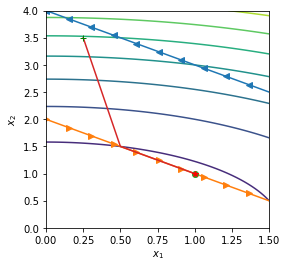

In [105]:
fig = plot_opthist(xhist)

We can see that the optimization process converges to the desired solution at $x= [1.0, 1.0]$.